In [4]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 15)
from pyspark.sql import SparkSession
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

hv.notebook_extension()


In [3]:
""" Interface for Data Ingestion.
"""
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


from __future__ import print_function
from __future__ import absolute_import
import os
import numpy as np
import pandas as pd 
import xarray as xr
import itertools
from glob import glob
# from pyspark.sql import SparkSession # Removing this line simply makes the library compatible with Spark 1.6.3 !

def ncread(sc, paths, mode='single', **kwargs):
    """Calls sparkxarray netcdf read function based on the mode parameter.

    ============ ==============================
    Mode          Reading Function
    ------------ ------------------------------
    single       : read_nc_single
    multi        : read_nc_multi
    Anything else: Throw an exception
    ============= ==============================

    Parameters
    ----------

    sc       :  sparkContext object

    paths    :  str or sequence
                Either a string glob in the form "path/to/my/files/*.nc" or an explicit
                list of files to open

    mode     : str
               'single' for a single file
               'multi' for multiple files

    **kwargs : dict
               partitioning options to be passed on to the actual read function.
            
    
    """

    if 'partitions' not in kwargs:
        kwargs['partitions'] = None

    if 'partition_on' not in kwargs:
        kwargs['partition_on'] = ['time']

    error_msg = ("You specified a mode that is not implemented.")

    if (mode == 'single'):
        return _read_nc_single(sc, paths, **kwargs)

    elif (mode == 'multi'):
        return _read_nc_multi(sc, paths, **kwargs)
    else:
        raise NotImplementedError(error_msg)

        
def _read_nc_single(sc, paths, **kwargs):
    """ Read a single netCDF file

    Parameters
    -----------
    sc       :  sparkContext object

    paths    :  str
                an explicit filename to open
    

    **kwargs : dict
               Additional arguments for partitioning 

    """
    partition_on = kwargs.get('partition_on')
    partitions = kwargs.get('partitions')

    dset = xr.open_dataset(paths, autoclose=True)

    # D = {'dim_1': dim_1_size, 'dim_2': dim_2_size, ...}
    D = {dset[dimension].name:dset[dimension].size for dimension in partition_on}
    
    # dim_sizes = [range(dim_1_size), range(dim_2_size), range(...)]
    dim_ranges = [range(dim_size) for dim_size in D.values()]
    

    dim_cartesian_product_indices = [element for element in itertools.product(*dim_ranges)]

    # create a list of dictionaries for  positional indexing
    positional_indices = [dict(zip(partition_on, ij)) for ij in dim_cartesian_product_indices]

    if not partitions:
        partitions = len(dim_cartesian_product_indices)

    if partitions > len(dim_cartesian_product_indices):
        partitions = len(dim_cartesian_product_indices)

    
    # Create an RDD
    rdd = sc.parallelize(positional_indices, partitions).map(lambda x: _readone_slice(dset, x))

    return rdd


def _readone_slice(dset, positional_indices):
    """Read a slice from an xarray.Dataset.

    Parameters
    ----------

    dset                : file_object
                         xarray.Dataset object
    positional_indices  : dict
                          dict containing positional indices for each dimension
                          e.g. {'lat': 0, 'lon': 0}

    Returns
    ---------
    chunk               : xarray.Dataset
                         a subset of the Xarray Dataset

    """

    # Change the positional indices into slice objects
    # e.g {'lat': 0, 'lon': 0} ---> {'lat': slice(0, 1, None),  'lon': slice(0, 1, None)}
    positional_slices = {dim: slice(positional_indices[dim], positional_indices[dim]+1) 
                                                         for dim in positional_indices}

    # Read a slice for the given positional_slices
    chunk = dset[positional_slices]
    return chunk


def _read_nc_multi(sc, paths, **kwargs):
    """ Read multiple netCDF files

    Parameters
    -----------
    sc       :  sparkContext object

    paths    :  str or sequence
                Either a string glob in the form "path/to/my/files/*.nc" or an explicit
                list of files to open

    **kwargs : dict
               Additional arguments for partitioning 

    """

    partition_on = kwargs.get('partition_on')
    partitions = kwargs.get('partitions')

    dset = xr.open_mfdataset(paths, autoclose=True)

    # D = {'dim_1': dim_1_size, 'dim_2': dim_2_size, ...}
    D ={dset[dimension].name:dset[dimension].size for dimension in partition_on}
    
    # dim_sizes = [range(dim_1_size), range(dim_2_size), range(...)]
    dim_ranges = [range(dim_size) for dim_size in D.values()]

    dim_cartesian_product_indices = [element for element in itertools.product(*dim_ranges)]

    # create a list of dictionaries for positional indexing
    positional_indices = [dict(zip(partition_on, ij)) for ij in dim_cartesian_product_indices]

    if not partitions:
        partitions = len(dim_cartesian_product_indices) / 50

    if partitions > len(dim_cartesian_product_indices):
        partitions = len(dim_cartesian_product_indices)

    
    # Create an RDD
    rdd = sc.parallelize(positional_indices, partitions).map(lambda x: readone_slice(dset, x))

    return rdd



In [5]:


# Create sparksession
spark = SparkSession.builder.appName("usa-shapefile").getOrCreate()
sc = spark.sparkContext



In [6]:
usa = GeoDataFrame.from_file("/home/abanihi/Documents/climate-data/shapefile/states/")
usa.head()

,CARPOOL,DRVALONE,EMPLOYED,FAMILIES,FEMALE,HOUSHOLD,LAND_KM,MALE,MANUAL,PERSONS,...,SAMP_POP,SERVICE,STATE_ABBR,STATE_FIPS,STATE_NAME,SUB_REGION,UNEMPLOY,WATER_KM,WORKERS,geometry
0,652603.0,3741715.0,5417967.0,2924880.0,5878369.0,4202240.0,143986.610,5552233.0,828906.0,11430602.0,...,1747776.0,1360159.0,IL,17,Illinois,E N Cen,385040.0,1993.335,4199206.0,"POLYGON ((-88.071564 37.51099000000001, -88.08..."
1,36621.0,106694.0,303994.0,122087.0,323930.0,249634.0,159.055,282970.0,22407.0,606900.0,...,72696.0,65498.0,DC,11,District of Columbia,S Atl,23442.0,17.991,229975.0,POLYGON ((-77.00823200000001 38.96655699999999...
2,42968.0,258087.0,335147.0,175867.0,343200.0,247497.0,5062.456,322968.0,44140.0,666168.0,...,102776.0,87973.0,DE,10,Delaware,S Atl,13945.0,1385.022,247566.0,"POLYGON ((-75.70742 38.55747600000001, -75.711..."
3,106918.0,493164.0,671085.0,500259.0,931941.0,688557.0,62384.200,861536.0,124172.0,1793477.0,...,317564.0,205950.0,WV,54,West Virginia,S Atl,71142.0,375.199,661702.0,"POLYGON ((-79.231903 38.48037299999999, -79.27..."
4,376449.0,1732837.0,2481342.0,1245814.0,2462797.0,1748991.0,25316.345,2318671.0,260308.0,4781468.0,...,684773.0,586994.0,MD,24,Maryland,S Atl,111536.0,6188.794,1783061.0,"(POLYGON ((-75.71106 38.649551, -75.70742 38.5..."


CPU times: user 480 ms, sys: 244 ms, total: 724 ms
Wall time: 638 ms


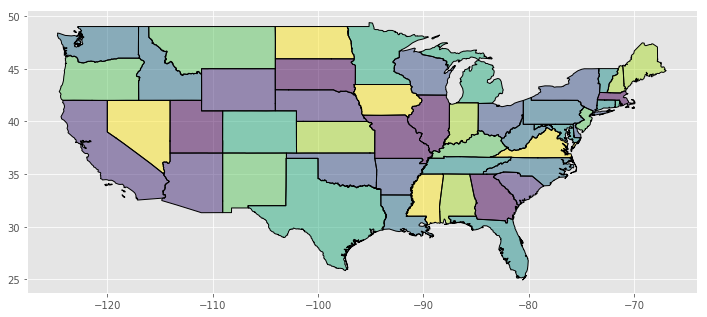

In [7]:
%time usa.plot();

In [12]:
filepath="/home/abanihi/Documents/climate-data/gpcp_1dd_v1.2_p1d.199610.nc"
shapefile="/home/abanihi/Documents/climate-data/shapefile/states/"

In [9]:
# Create an RDD (Resilient Distributed Datasets)
rdd = ncread(sc, filepath, partition_on=['lat', 'lon'], partitions=700).cache()

In [10]:


%time rdd.count()



CPU times: user 84 ms, sys: 44 ms, total: 128 ms
Wall time: 1min 4s


64800

In [11]:
rdd.first()

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, time: 31)
Coordinates:
  * lon      (lon) float64 -179.5
  * lat      (lat) float64 -89.5
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
Data variables:
    precip   (time, lat, lon) float64 0.4793 0.3221 0.0 0.4259 1.239 0.4496 ...
Attributes:
    Conventions:           CF-1.6
    title:                 GPCP 1DD V1.2 Combined Data Sets
    technique:             1dd
    version:               1.2
    prod_date:             2012-09-18
    institution:           Mesoscale Atmospheric Processes Laboratory, NASA G...
    contact:               Mr. D. Smith, NCDC, Rm. 120, 151 Patton Ave, Ashvi...
    telephone:             828-271-4053
    facsimile:             828-271-4328
    email:                 dsmith@ncdc.noaa.gov
    url:                   http://precip.gsfc.nasa.gov/
    acknowledgments:       The 1DD data were provided by the NASA/Goddard Spa...
    documentation:         http://rda.ucar.edu/datasets/ds728.

In [66]:
# -*- coding: utf-8 -*-
""" Masking an area in a netCDF dataset using a geographical outline.
This module reads a shapefile using geopandas. The user have the option 
of masking the area inside or outside the geographical outline.
"""

import warnings
warnings.filterwarnings('ignore')
import xarray as xr 
import geopandas as gpd 
from geopandas import GeoDataFrame  # Loading boundaries data
from shapely.geometry import Point, Polygon, shape # For creating geospatial data
import time
from functools import partial 


def _shift_lon_values(dset):
    from shapely.geometry import Point 
    lat = dset.lat.values 
    lon = dset.lon.values 

    if lon >= 180:
        lon = lon - 360.

    coordinate = Point(lon, lat)
    return coordinate, dset 
    


def masking(sc, rdd, shapefile_path, mask_area='in'):

    print("Loading and broadcasting the shapefile....\n\n")
    shape = GeoDataFrame.from_file(shapefile_path)

    my_shape = sc.broadcast(shape)
    print("Successfully loaded the shapefile....\n\n")

    print("Masking the data against the shapefile in progress....\n\n")
    start = time.time()
    masked_rdd = rdd.map(_shift_lon_values).filter(partial(_point_look_up, my_shape))\
              .collect()
    masked_data = [item[1] for item in masked_rdd]
    
    dset = xr.auto_combine(masked_data, concat_dim=None)
    
    stop = time.time()
    total_time = stop - start 
    print("Successfully masked the data in {} seconds\n".format(round(total_time, 3)))
    return dset
    


def _point_look_up(my_shape, element):
    grid_point = element[0]
    dset = element[1]

    # Access the broadcasted shape on the workers
    gdf = my_shape.value 

    # See if the grid point i s inside the shape
    check = gdf.contains(grid_point).unique()


    if True in check:
        return True
    else:
        return False


In [67]:
rdd2 = masking(sc, rdd, shapefile)

Loading and broadcasting the shapefile....


Successfully loaded the shapefile....


Masking the data against the shapefile in progress....


Successfully masked the data in 55.753 seconds



In [69]:
rdd2

<xarray.Dataset>
Dimensions:  (lat: 24, lon: 57, time: 31)
Coordinates:
  * lat      (lat) float64 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 ...
  * lon      (lon) float64 -123.5 -122.5 -121.5 -120.5 -119.5 -118.5 -117.5 ...
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
Data variables:
    precip   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [48]:
rdd2.count()

816

In [49]:
%time usa_data = rdd2.collect()

CPU times: user 272 ms, sys: 40 ms, total: 312 ms
Wall time: 57.5 s


In [52]:
usa_data

[(<shapely.geometry.point.Point at 0x7f09f415abe0>, <xarray.Dataset>
  Dimensions:  (lat: 1, lon: 1, time: 31)
  Coordinates:
    * lon      (lon) float64 -80.5
    * lat      (lat) float64 25.5
    * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
  Data variables:
      precip   (time, lat, lon) float64 5.524 1.945 14.43 8.353 3.731 10.76 ...
  Attributes:
      Conventions:           CF-1.6
      title:                 GPCP 1DD V1.2 Combined Data Sets
      technique:             1dd
      version:               1.2
      prod_date:             2012-09-18
      institution:           Mesoscale Atmospheric Processes Laboratory, NASA G...
      contact:               Mr. D. Smith, NCDC, Rm. 120, 151 Patton Ave, Ashvi...
      telephone:             828-271-4053
      facsimile:             828-271-4328
      email:                 dsmith@ncdc.noaa.gov
      url:                   http://precip.gsfc.nasa.gov/
      acknowledgments:       The 1DD data were provided b

In [54]:
data = [item[1] for item in usa_data]

In [55]:
%time dset = xr.auto_combine(data, concat_dim=None)

CPU times: user 1.92 s, sys: 176 ms, total: 2.1 s
Wall time: 2.22 s


In [56]:
dset

<xarray.Dataset>
Dimensions:  (lat: 24, lon: 57, time: 31)
Coordinates:
  * lat      (lat) float64 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 ...
  * lon      (lon) float64 -123.5 -122.5 -121.5 -120.5 -119.5 -118.5 -117.5 ...
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 1996-10-03 ...
Data variables:
    precip   (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

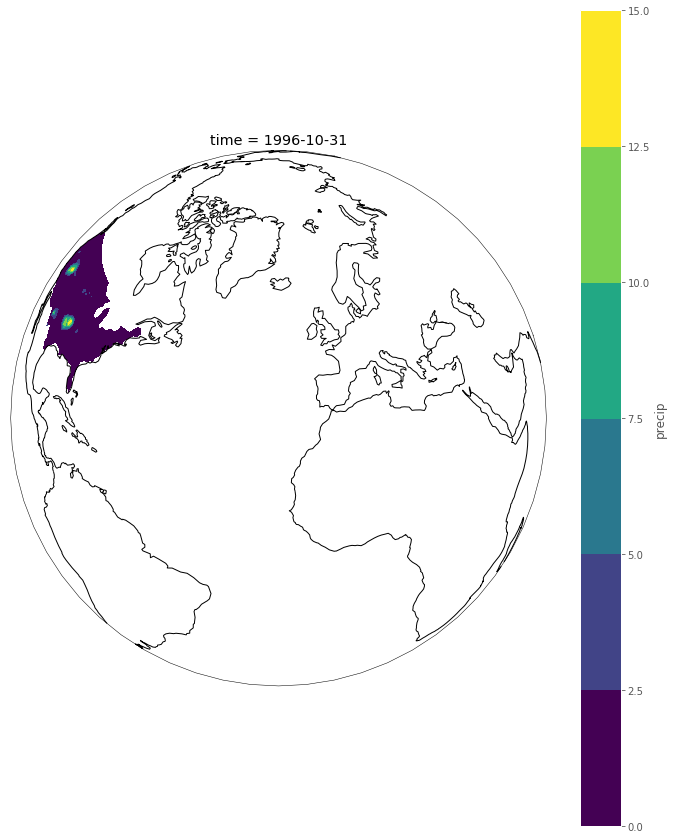

In [58]:
%%opts Image [colorbar=True, fig_size=200] (cmap='viridis')
ax = plt.axes(projection=crs.Orthographic(-20, 35))
dset.precip.isel(time=30).plot.contourf(ax=ax, transform=crs.PlateCarree());
ax.set_global(); ax.coastlines();